In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import RFE, SelectFromModel, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from boruta import BorutaPy

import time

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
X = pd.read_csv('secom/secom.data', sep=' ', header=None)
feature_names = [f'feature{i+1}' for i in range(X.shape[1])]
X.columns = feature_names
X.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [3]:
y = pd.read_csv('secom/secom_labels.data', sep=' ', header=None)
label_columns = ['label', 'date_time']
y.columns = label_columns
y.head()

,label,date_time
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


In [4]:
# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y['label']
)

In [5]:
# Check the sizes of the resulting datasets
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Training set size: 1175, Test set size: 392


In [6]:
# Checking Class Distributions after splitting the data
print('Original label distribution: ')
print(y['label'].value_counts(normalize=True))

print('\nTraining label distribution: ')
print(y_train['label'].value_counts(normalize=True))

print('\nTest label distribution: ')
print(y_test['label'].value_counts(normalize=True))

Original label distribution: 
label
-1    0.933631
 1    0.066369
Name: proportion, dtype: float64

Training label distribution: 
label
-1    0.933617
 1    0.066383
Name: proportion, dtype: float64

Test label distribution: 
label
-1    0.933673
 1    0.066327
Name: proportion, dtype: float64


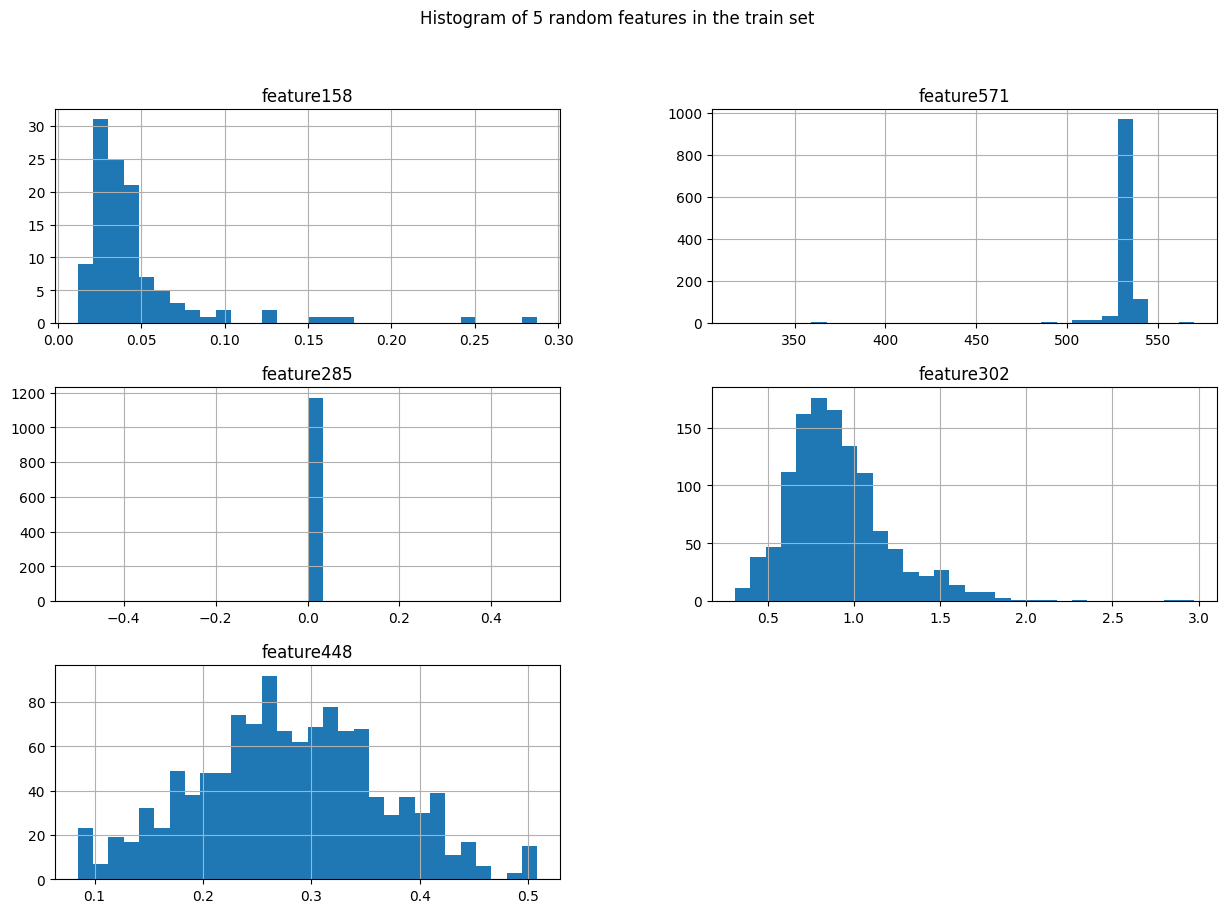

In [7]:
# Descriptive Analysis on the Test Set
X_train.sample(5, axis=1).hist(bins=30, figsize=(15, 10))
plt.suptitle('Histogram of 5 random features in the train set')
plt.show()

In [8]:
# Checking for duplicate rows
duplicates = X_train.duplicated()

# Count the number of duplicates
no_of_duplicates = duplicates.sum()
print(f'Number of duplicated rows in X_train: {no_of_duplicates}')

Number of duplicated rows in X_train: 0


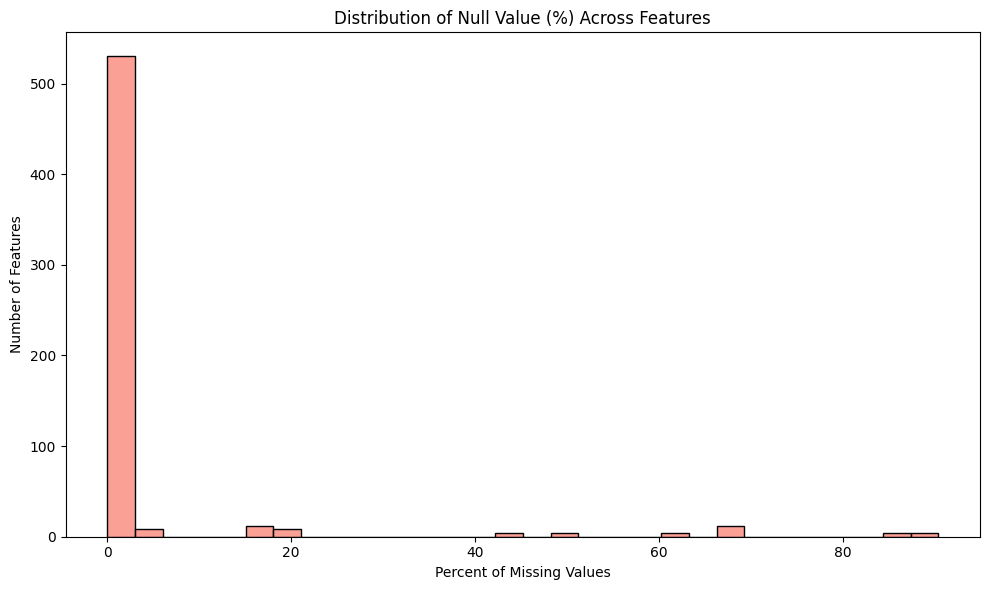

In [9]:
# Distribution of Null Values across features
missing_percent_per_feature = (X_train.isnull().sum() / len(X_train)) * 100

plt.figure(figsize=(10,6))
sns.histplot(missing_percent_per_feature, bins=30, kde=False, color='salmon')
plt.title('Distribution of Null Value (%) Across Features')
plt.xlabel('Percent of Missing Values')
plt.ylabel('Number of Features')
plt.tight_layout()
plt.show()

features_with_high_null_values = missing_percent_per_feature[
    missing_percent_per_feature >= 44.5].index.tolist()

In [10]:
print(f"Number of features with a high proportion of null values: {len(features_with_high_null_values)}")
print("High proportion of null value features:", features_with_high_null_values)

Number of features with a high proportion of null values: 32
High proportion of null value features: ['feature73', 'feature74', 'feature86', 'feature110', 'feature111', 'feature112', 'feature113', 'feature158', 'feature159', 'feature221', 'feature245', 'feature246', 'feature247', 'feature248', 'feature293', 'feature294', 'feature346', 'feature347', 'feature359', 'feature383', 'feature384', 'feature385', 'feature386', 'feature493', 'feature517', 'feature518', 'feature519', 'feature520', 'feature579', 'feature580', 'feature581', 'feature582']


In [11]:
# Finding features with no volatility (i.e. std dev = 0)
zero_std_dev_cols = X_train.loc[:, X_train.std() == 0].columns
zero_std_dev_cols = list(zero_std_dev_cols)
print(f"Number of zero-variance features: {len(zero_std_dev_cols)}")
print("Zero-variance features:", zero_std_dev_cols)

Number of zero-variance features: 116
Zero-variance features: ['feature6', 'feature14', 'feature43', 'feature50', 'feature53', 'feature70', 'feature98', 'feature142', 'feature150', 'feature179', 'feature180', 'feature187', 'feature190', 'feature191', 'feature192', 'feature193', 'feature194', 'feature195', 'feature227', 'feature230', 'feature231', 'feature232', 'feature233', 'feature234', 'feature235', 'feature236', 'feature237', 'feature238', 'feature241', 'feature242', 'feature243', 'feature244', 'feature257', 'feature258', 'feature259', 'feature260', 'feature261', 'feature262', 'feature263', 'feature264', 'feature265', 'feature266', 'feature267', 'feature277', 'feature285', 'feature314', 'feature315', 'feature316', 'feature323', 'feature326', 'feature327', 'feature328', 'feature329', 'feature330', 'feature331', 'feature365', 'feature370', 'feature371', 'feature372', 'feature373', 'feature374', 'feature375', 'feature376', 'feature379', 'feature380', 'feature381', 'feature382', 'featur

In [12]:
# Combining the list of features that have a high percent of missing values and features that have 0 volatility to eventually drop
features_to_drop = features_with_high_null_values + zero_std_dev_cols
print(len(features_to_drop))

148


In [13]:
# Drop the identified features from train set for now
X_train_cleaned = X_train.drop(columns=features_to_drop)
# X_test_cleaned = X_test.drop(columns=features_to_drop)

print(f"Remaining features after drop: {X_train_cleaned.shape[1]} features.")

Remaining features after drop: 442 features.


In [14]:
y_train_arr = y_train.drop(columns='date_time')
y_train_arr = y_train_arr.to_numpy().ravel()

In [15]:
y_train_arr.shape

(1175,)

In [16]:
type(X_train_cleaned)

pandas.core.frame.DataFrame

In [57]:
# Correlation Filter
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.to_drop_ = []

    def fit(self, X, y):
        # print("[CorrelationFilter] fit called.")
        df = pd.DataFrame(X)
        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Compute mutual information with target
        mi_scores = mutual_info_classif(df, y)
        mi_series = pd.Series(mi_scores, index=df.columns)

        to_drop = set()
        for i in range(len(upper.columns)):
            col = upper[i]
            for j in range(i):
                row = upper.index[j]
                if upper.iloc[j, i] > self.threshold:
                    # Compare MI and drop the lower one
                    if mi_series[col] < mi_series[row]:
                        to_drop.add(col)
                    else:
                        to_drop.add(row)
        
        self.to_drop_ = list(to_drop)
        return self

    def transform(self, X):
        # print("[CorrelationFilter] transform called.")
        df = pd.DataFrame(X)
        return df.drop(columns=self.to_drop_, errors='ignore').to_numpy()

In [40]:
# Feature Selectors
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, method='rfe', estimator=None, n_features_to_select=25, n_estimators=100, max_iter=100):
        self.method = method
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select
        self.n_estimators = n_estimators
        self.max_iter = max_iter

    def fit(self, X, y):
        # print("[FeatureSelector] fit called.")
        X = np.array(X)
        
        if self.method == 'rfe':
            if self.estimator is None:
                raise ValueError("An estimator must be provided for RFE.")
            self.selector_ = RFE(estimator=clone(self.estimator), n_features_to_select=self.n_features_to_select)
        elif self.method == 'lasso':
            self.selector_ = SelectFromModel(Lasso(alpha=0.01, random_state=42))
        elif self.method == 'boruta':
            # Using BorutaPy for feature selection
            if self.estimator is None:
                self.estimator = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
            self.selector_ = BorutaPy(estimator=self.estimator,
                                  n_estimators=self.n_estimators,
                                  max_iter=self.max_iter,
                                  random_state=42)
        else:
            raise ValueError("Unsupported method. Use 'rfe', 'lasso' or 'boruta'.")
            
        self.selector_.fit(X, y)
        # print("[FeatureSelector] fit complete.")
        return self

    def transform(self, X):
        # print("[FeatureSelector] transform called.")
        if not hasattr(self, 'selector_'):
            raise RuntimeError("You must fit the transformer before calling transform.")
        return self.selector_.transform(np.array(X))

    def get_support(self):
        if not hasattr(self, 'selector_'):
            raise RuntimeError("fit() must be called before get_support().")

        # For Boruta, useing support_ attribute directly
        if self.method == 'boruta':
            return self.selector_.support_

        # For RFE and Lasso, using get_support() method
        return self.selector_.get_support()

In [42]:
# Define pipeline components
imputers = {
    "median": SimpleImputer(strategy="median"),
    "knn": KNNImputer(n_neighbors=5),
    "mice": IterativeImputer(random_state=42)
}

feature_selectors = {
    "rfe": FeatureSelector(method='rfe', estimator=LogisticRegression(max_iter=1000), n_features_to_select=25),
    "lasso": FeatureSelector(method='lasso'),
    "boruta": FeatureSelector(method='boruta', estimator=None, n_estimators=100, max_iter=100)
}

balancers = {
    "SMOTE": SMOTE(random_state=42, n_jobs=-1),
    "ADASYN": ADASYN(random_state=42, n_jobs=-1)
}

models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    "SVC": SVC(probability=True, random_state=42)
}

scoring = {
    'f1': make_scorer(f1_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1)
}

In [62]:
# Run cross-validation for all combinations
results = []

run_count = 0
max_runs = 10

for imp_name, imputer in imputers.items():
    for fs_name, selector in feature_selectors.items():
        for bal_name, balancer in balancers.items():
            for model_name, model in models.items():
                if run_count >= max_runs:
                    break
                try:
                    pipe = ImbPipeline([
                        ('impute', imputer),
                        ('corr', CorrelationFilter(threshold=0.8)),
                        ('select', selector),
                        ('scale', StandardScaler()),
                        ('balance', balancer),
                        ('clf', model)
                    ])

                    # Define the pipeline name for logging
                    name = f"{imp_name}_{fs_name}_{bal_name}_{model_name}"
                    print(f"\nTraining {name}...")

                    # Start timing
                    start_time = time.time()

                    # Cross-validation setup
                    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                    scores = cross_validate(pipe, X_train_cleaned, y_train_arr, scoring=scoring, cv=cv)

                    # Measure execution time
                    execution_time = round(time.time() - start_time, 2)

                    pipe.fit(X_train_cleaned, y_train_arr)

                    # Get the number of features selected after correlation and feature selection
                    selector_step = pipe.named_steps.get('select', None)
                    n_features_selected = None
                    
                    if selector_step is not None and hasattr(selector_step, 'get_support'):
                        n_features_selected = np.sum(selector_step.get_support())
                    else:
                        # fallback if get_support isn't available
                        n_features_selected = 'unknown'
                    
                    results.append({
                        'Pipeline': name,
                        'F1': np.mean(scores['test_f1']),
                        'Precision': np.mean(scores['test_precision']),
                        'Recall': np.mean(scores['test_recall']),
                        'Num Features Selected': n_features_selected,
                        'Execution Time (s)': execution_time
                    })

                    run_count += 1

                    
                except Exception as e:
                    print(f"Pipeline {name} failed: {e}")


Training median_rfe_SMOTE_RandomForest...


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warning


Training median_rfe_SMOTE_LogisticRegression...


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warning


Training median_rfe_SMOTE_SVC...


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warning


Training median_rfe_ADASYN_RandomForest...


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\U


Training median_rfe_ADASYN_LogisticRegression...


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\U


Training median_rfe_ADASYN_SVC...


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\U


Training median_lasso_SMOTE_RandomForest...


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warning


Training median_lasso_SMOTE_LogisticRegression...


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warning


Training median_lasso_SMOTE_SVC...


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set inste


Training median_lasso_ADASYN_RandomForest...


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  wa

In [63]:
# Results DataFrame
results_df = pd.DataFrame(results).sort_values(by='F1', ascending=False)

top_results = results_df.head(10)

In [64]:
top_results

,Pipeline,F1,Precision,Recall,Num Features Selected,Execution Time (s)
7,median_lasso_SMOTE_LogisticRegression,0.179012,0.119945,0.359167,92,21.62
3,median_rfe_ADASYN_RandomForest,0.160655,0.225325,0.128333,25,325.76
1,median_rfe_SMOTE_LogisticRegression,0.153246,0.094006,0.423333,25,330.33
4,median_rfe_ADASYN_LogisticRegression,0.151222,0.092393,0.421667,25,325.76
2,median_rfe_SMOTE_SVC,0.148067,0.135576,0.165833,25,326.55
5,median_rfe_ADASYN_SVC,0.139355,0.120111,0.168333,25,331.16
0,median_rfe_SMOTE_RandomForest,0.138061,0.206508,0.104167,25,311.85
8,median_lasso_SMOTE_SVC,0.103258,0.273333,0.064167,86,18.60
9,median_lasso_ADASYN_RandomForest,0.086550,0.333333,0.050000,90,19.42
6,median_lasso_SMOTE_RandomForest,0.067974,0.400000,0.037500,92,19.11


Was debugging. Needn't run whatever is below

In [30]:
results2 = []
try:
    print("[Pipeline] Creating pipeline...")
    pipe = ImbPipeline([
        ('impute', SimpleImputer(strategy="median")),
        ('corr', CorrelationFilter(threshold=0.8)),
        ('select', FeatureSelector(method='rfe', estimator=LogisticRegression(max_iter=1000), n_features_to_select=20)),
        ('scale', StandardScaler()),
        ('balance', SMOTE(random_state=42, n_jobs=-1)),
        ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])

    # Define the pipeline name for logging
    name = 'model_' # f"{imp_name}_{fs_name}_{bal_name}_{model_name}"
    print(f"\nTraining {name}...")

    # Start timing
    start_time = time.time()

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print("[Pipeline] Starting cross-validation...")
    scores = cross_validate(pipe, X_train_cleaned, y_train_arr, scoring=scoring, cv=cv)

    # Measure execution time
    execution_time = round(time.time() - start_time, 2)
    print("[Pipeline] Cross-validation complete.")

    pipe.fit(X_train_cleaned, y_train_arr)

    # Get the number of features selected after correlation and feature selection
    selector_step = pipe.named_steps.get('select', None)
    n_features_selected = None
    
    if selector_step is not None and hasattr(selector_step, 'get_support'):
        n_features_selected = np.sum(selector_step.get_support())
    else:
        # fallback if get_support isn't available
        n_features_selected = 'unknown'
    
    results2.append({
        'Pipeline': name,
        'F1': np.mean(scores['test_f1']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'Num Features Selected': n_features_selected,
        'Execution Time (s)': execution_time
    })
                         
except Exception as e:
    print(f"Pipeline {name} failed: {e}")

[Pipeline] Creating pipeline...

Training model_...
[Pipeline] Starting cross-validation...
[CorrelationFilter] fit called.
[CorrelationFilter] transform called.
[FeatureSelector] fit called.
[FeatureSelector] fit complete.
[FeatureSelector] transform called.


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[CorrelationFilter] transform called.
[FeatureSelector] transform called.
[CorrelationFilter] fit called.
[CorrelationFilter] transform called.
[FeatureSelector] fit called.
[FeatureSelector] fit complete.
[FeatureSelector] transform called.


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[CorrelationFilter] transform called.
[FeatureSelector] transform called.
[CorrelationFilter] fit called.
[CorrelationFilter] transform called.
[FeatureSelector] fit called.
[FeatureSelector] fit complete.
[FeatureSelector] transform called.


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[CorrelationFilter] transform called.
[FeatureSelector] transform called.
[CorrelationFilter] fit called.
[CorrelationFilter] transform called.
[FeatureSelector] fit called.
[FeatureSelector] fit complete.
[FeatureSelector] transform called.


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[CorrelationFilter] transform called.
[FeatureSelector] transform called.
[CorrelationFilter] fit called.
[CorrelationFilter] transform called.
[FeatureSelector] fit called.
[FeatureSelector] fit complete.
[FeatureSelector] transform called.


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[CorrelationFilter] transform called.
[FeatureSelector] transform called.
[Pipeline] Cross-validation complete.
[CorrelationFilter] fit called.
[CorrelationFilter] transform called.
[FeatureSelector] fit called.
[FeatureSelector] fit complete.
[FeatureSelector] transform called.


C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [31]:
results2

[{'Pipeline': 'model_',
  'F1': 0.1741072840203275,
  'Precision': 0.23714285714285716,
  'Recall': 0.1408333333333333,
  'Num Features Selected': 20,
  'Execution Time (s)': 277.48}]

In [58]:
results2 = []
try:
    print("[Pipeline] Creating pipeline...")
    pipe = ImbPipeline([
        ('impute', KNNImputer(n_neighbors=5)),
        ('corr', CorrelationFilter(threshold=0.8)),
        ('select', FeatureSelector(method='boruta', estimator=None, n_estimators=100, max_iter=100)),
        ('scale', StandardScaler()),
        ('balance', SMOTE(random_state=42, n_jobs=-1)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
    ])

    # Define the pipeline name for logging
    name = 'model_' # f"{imp_name}_{fs_name}_{bal_name}_{model_name}"
    print(f"\nTraining {name}...")

    # Start timing
    start_time = time.time()

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print("[Pipeline] Starting cross-validation...")
    scores = cross_validate(pipe, X_train_cleaned, y_train_arr, scoring=scoring, cv=cv)

    # Measure execution time
    execution_time = round(time.time() - start_time, 2)
    print("[Pipeline] Cross-validation complete.")

    pipe.fit(X_train_cleaned, y_train_arr)

    # Get the number of features selected after correlation and feature selection
    selector_step = pipe.named_steps.get('select', None)
    n_features_selected = None
    
    if selector_step is not None and hasattr(selector_step, 'get_support'):
        n_features_selected = np.sum(selector_step.get_support())
    else:
        # fallback if get_support isn't available
        n_features_selected = 'unknown'
    
    results2.append({
        'Pipeline': name,
        'F1': np.mean(scores['test_f1']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'Num Features Selected': n_features_selected,
        'Execution Time (s)': execution_time
    })
                         
except Exception as e:
    print(f"Pipeline {name} failed: {e}")

[Pipeline] Creating pipeline...

Training model_...
[Pipeline] Starting cross-validation...
Pipeline model_ failed: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\MadhavKoodanaMadhu\Documents\MPMD\Sem2\Adv_Data_Analytics\project\venv\lib\site-packages\imblearn\pipeline.

In [48]:
results2

[{'Pipeline': 'model_',
  'F1': 0.1309125656951744,
  'Precision': 0.18722943722943722,
  'Recall': 0.1025,
  'Num Features Selected': 25,
  'Execution Time (s)': 283.03}]